<a href="https://colab.research.google.com/github/chidinma-godwin/course-recommendation-nlp/blob/main/course_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence_transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Suppress the TqdmExperimentalWarning
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings('ignore', category=TqdmExperimentalWarning)

In [4]:
import re
import string

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

## Data Exploration

In [5]:
base_dir = "/content/drive/MyDrive/project"

df = pd.read_csv(f"{base_dir}/courseslist.csv")
df.head()

,additional_course_detail,course_avg_rating,course_certificate,course_institution,course_is_classroom,course_is_university,course_level,course_link,course_name,course_num_rating,course_provider,course_subject,course_type,description,duration,is_all_time_best,pricing,start_date,teacher
0,Welcome to the world of programming! Learn the...,4.84906,True,NaN,False,False,beginner,https://www.classcentral.com/course/intro-to-p...,Introduction to Programming,53,Udacity,Programming,microcredential,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,"Karl Krueger, Kelly Howard, Julia Van Cleve, J..."
1,",This course bridges the gap between introduct...",3.66667,True,Harvard University,False,True,intermediate,https://www.classcentral.com/course/python-har...,Using Python for Research,12,edX,Programming,course,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Jukka-Pekka JP Onnela
2,This course takes Java beginners to the next l...,4.45000,True,University of Alberta,False,True,intermediate,https://www.classcentral.com/course/object-ori...,Object-Oriented Design,40,Coursera,Programming,course,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Kenny Wong
3,This Specialization builds on the success of t...,4.88462,True,University of Michigan,False,True,beginner,https://www.classcentral.com/course/python-186...,Python for Everybody,416,Coursera,Python,microcredential,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Charles Russell Severance
4,This course will introduce the core data struc...,4.89328,True,University of Michigan,False,True,beginner,https://www.classcentral.com/course/python-dat...,Python Data Structures,16426,Coursera,Python,course,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Charles Severance


In [6]:
df.duplicated().sum()

0

In [7]:
df = df.replace(np.nan, None)
df.isna().sum()

additional_course_detail        0
course_avg_rating               0
course_certificate              0
course_institution          20813
course_is_classroom             0
course_is_university            0
course_level                16715
course_link                     0
course_name                     0
course_num_rating               0
course_provider                 0
course_subject                  0
course_type                     0
description                     0
duration                       65
is_all_time_best                0
pricing                         0
start_date                      0
teacher                     10840
dtype: int64

In [8]:
df['course_subject'].value_counts().reset_index().set_index('course_subject')

,count
course_subject,
Python,1332
Microsoft Azure,1198
Google Cloud Platform (GCP),1111
Uncategorized,1008
Javascript,812
...,...
Culture,1
IT Compliance,1
LDAP,1


In [9]:
df['course_level'].value_counts(dropna=False).reset_index().set_index('course_level')

,count
course_level,
None,16715
beginner,11844
intermediate,5625
advanced,979


In [10]:
df['pricing'].value_counts().reset_index()

,pricing,count
0,Free Online Course,11498
1,Free Trial Available,9615
2,Paid Course,9502
3,Free Online Course (Audit),2987
4,Conference Talk,747
5,Free Certificate,525
6,$14.00,28
7,"$7,500.00",15
8,$297.00,15
9,$34.00,15


In [11]:
df['course_is_university'].value_counts().reset_index().set_index('course_is_university')

,count
course_is_university,
False,32392
True,2771


In [12]:
df['course_provider'].value_counts().reset_index().set_index('course_provider')

,count
course_provider,
YouTube,8452
Udemy,8248
Pluralsight,4389
Coursera,3711
LinkedIn Learning,3620
...,...
Marginal Revolution University,1
OpenLearning,1
Stepik,1


In [13]:
df[df['course_subject'] == 'Uncategorized'].head()

,additional_course_detail,course_avg_rating,course_certificate,course_institution,course_is_classroom,course_is_university,course_level,course_link,course_name,course_num_rating,course_provider,course_subject,course_type,description,duration,is_all_time_best,pricing,start_date,teacher
478,"Introduction,Project Overview,Case Scenario,Al...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,Picking on the Same Person - Does Algorithmic ...,0,YouTube,Uncategorized,course,Stanford University offers a brief seminar exp...,35 minutes,False,Free Online Course,On-Demand,None
479,"Introduction,Linear approach,landscape changes...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,"AI, Archaeology, and Archives - How Data Scien...",0,YouTube,Uncategorized,course,Stanford University offers a brief seminar exp...,35 minutes,False,Free Online Course,On-Demand,None
480,"Introduction,Our Story Begins,The History of t...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,"Voices in the Code - A Story About People, The...",0,YouTube,Uncategorized,course,Stanford University offers a brief seminar exp...,35 minutes,False,Free Online Course,On-Demand,None
497,Stanford Seminar: PyWren - Pushing Microservic...,0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,Stanford Seminar - PyWren - Pushing Microservi...,0,YouTube,Uncategorized,course,Stanford University offers a brief seminar on ...,45 minutes,False,Free Online Course,On-Demand,None
498,"Stanford Seminar: Data For The People, Andreas...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,Data for the People - Andreas Weigend of Socia...,0,YouTube,Uncategorized,course,Stanford University offers a brief seminar on ...,45 minutes,False,Free Online Course,On-Demand,None


## Data Preprocessing

In [14]:
# Function to create a meaningful combined course details
def create_combined_details(row):
    teacher_and_duration = ""
    if row['teacher'] and row['duration']:
        teacher_and_duration = f"The course was taught by {row['teacher']} and has a duration of {row['duration']}"
    elif row['teacher']:
        teacher_and_duration = f"The course was taught by {row['teacher']}"
    elif row['duration']:
        teacher_and_duration = f"The course has a duration of {row['duration']}"

    certificate = " You can get a certificate after completing this course" if row['course_certificate'] else ""

    course_institution = f" by {row['course_institution']}" if row['course_institution'] else ""

    course_level = f" and is classified as {row['course_level']} level" if row['course_level'] else ""

    combined_details = (
        f"""{row['course_name']}: This {re.sub(r' Course', '', row['pricing'])} course was rated by \
{row['course_num_rating']} people with an average rating of {round(row['course_avg_rating'], 1)}. {teacher_and_duration}. \
This {row['course_subject']} course is offered on {row['course_provider']}{course_institution}{course_level}.{certificate}. {row['additional_course_detail']}. {row['description']}"""
    )
    return combined_details

In [15]:
# Apply the function to each row to create the combined text
df["combined_details"] = df.apply(create_combined_details, axis=1)
df["combined_details"][0]

'Introduction to Programming: This Paid course was rated by 53 people with an average rating of 4.8. The course was taught by Karl Krueger, Kelly Howard, Julia Van Cleve, James Parkes, Richard Kalehoff, Greg C., Yodit F., Matthew R., John M., Vincenzo A. and James L. and has a duration of 4 months 3 weeks. This Programming course is offered on Udacity and is classified as beginner level. You can get a certificate after completing this course. Welcome to the world of programming! Learn the skills that all programmers use, whether they build apps, web pages, or analyze data.,,. Master coding basics with this 17-week Udacity course. Learn HTML, CSS, Python, and JavaScript, with no prior programming skills required. Ideal for beginners eyeing careers in tech.'

In [16]:
print("Min: ", min(df["combined_details"].str.split().apply(len)))
print("Max: ", max(df["combined_details"].str.split().apply(len)))

Min:  50
Max:  5448


In [17]:
# Download NLTK data
nltk.download('stopwords')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
nlp = spacy.load('en_core_web_sm')

def preprocess_texts(texts):
    preprocessed_texts = []

    for text in texts:
        text = text.lower()
        text = re.sub(r'(?<=\d)[.](?=\d)', '√√√DOT√√√', text)  # Temporarily replace "." between numbers
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove all punctuations
        text = re.sub(r'√√√DOT√√√', '.', text)  # Restore the preserved "."
        preprocessed_texts.append(text)

    lemmatized_texts = []

    for doc in nlp.pipe(preprocessed_texts, n_process=4, disable=["parser", "ner", "textcat"]):
        words = [token.lemma_ for token in doc if token.text not in stop_words]
        lemmatized_texts.append(' '.join(words))

    return lemmatized_texts

df['preprocessed_details'] = preprocess_texts(df['combined_details'])
df['preprocessed_details'][0]

'introduction program pay course rate 53 people average rating 4.8 course teach karl krueger kelly howard julia van cleve james parkes richard kalehoff greg c yodit f matthew r john vincenzo james l duration 4 month 3 week programming course offer udacity classify beginner level get certificate complete course welcome world programming learn skill programmer use whether build app web page analyze data master code basic 17week udacity course learn html css python javascript prior programming skill require ideal beginner eye career tech'

In [25]:
print("Min: ", min(df["preprocessed_details"].str.split().apply(len)))
print("Max: ", max(df["preprocessed_details"].str.split().apply(len)))

Min:  30
Max:  2841


## Data Visualization

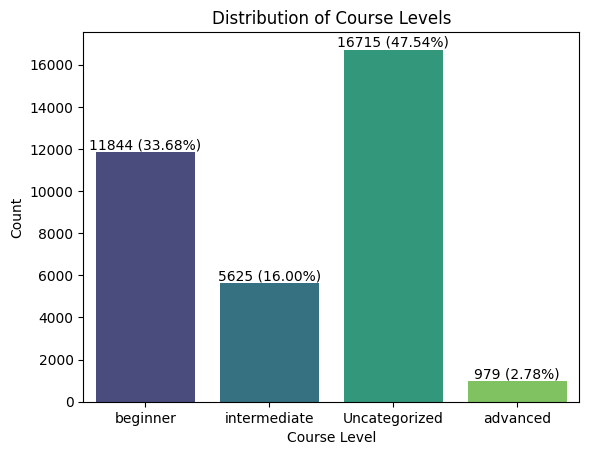

In [146]:
filled_df = df['course_level'].fillna('Uncategorized', inplace=False)
ax = sns.countplot(x=filled_df, data=df, palette='viridis', hue=filled_df)
ax.set_title('Distribution of Course Levels')
ax.set_xlabel('Course Level')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = round(rect.get_height())
    percentage = (height / len(filled_df)) * 100
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=f'{height} ({percentage:.2f}%)', ha='center', va='bottom')

plt.show()

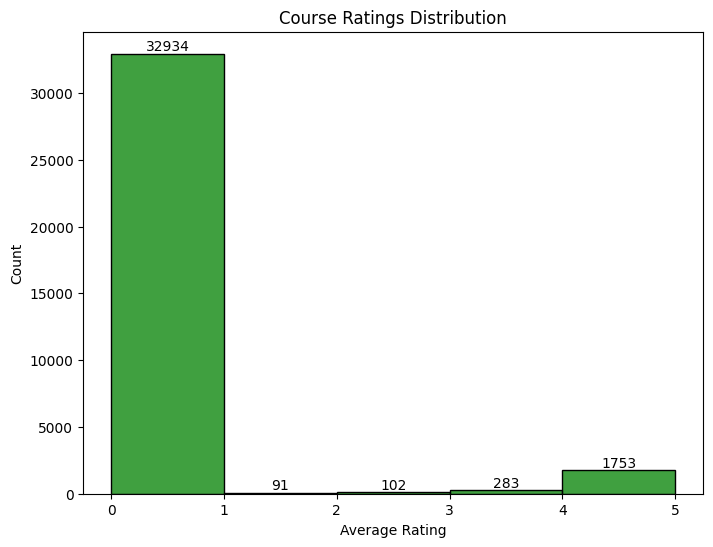

In [147]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df['course_avg_rating'], bins=5, color='green', ax=ax)
ax.set_title('Course Ratings Distribution')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = rect.get_height()
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=height, ha='center', va='bottom')

plt.show()

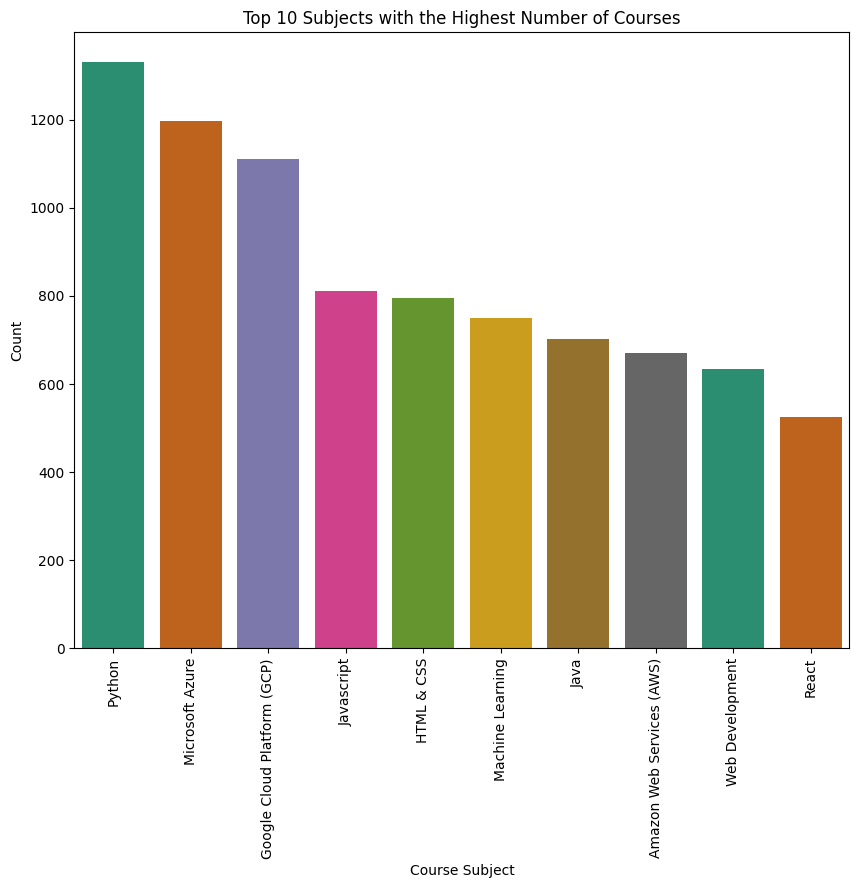

In [188]:
top_subjects = df[df['course_subject'] != 'Uncategorized']['course_subject'].value_counts().reset_index()[:10]

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x='course_subject', y='count', data=top_subjects, palette='Dark2', hue='course_subject', ax=ax)
ax.set_title('Top 10 Subjects with the Highest Number of Courses')
ax.set_xlabel('Course Subject')
ax.set_ylabel('Count')

plt.xticks(rotation=90)
plt.show()

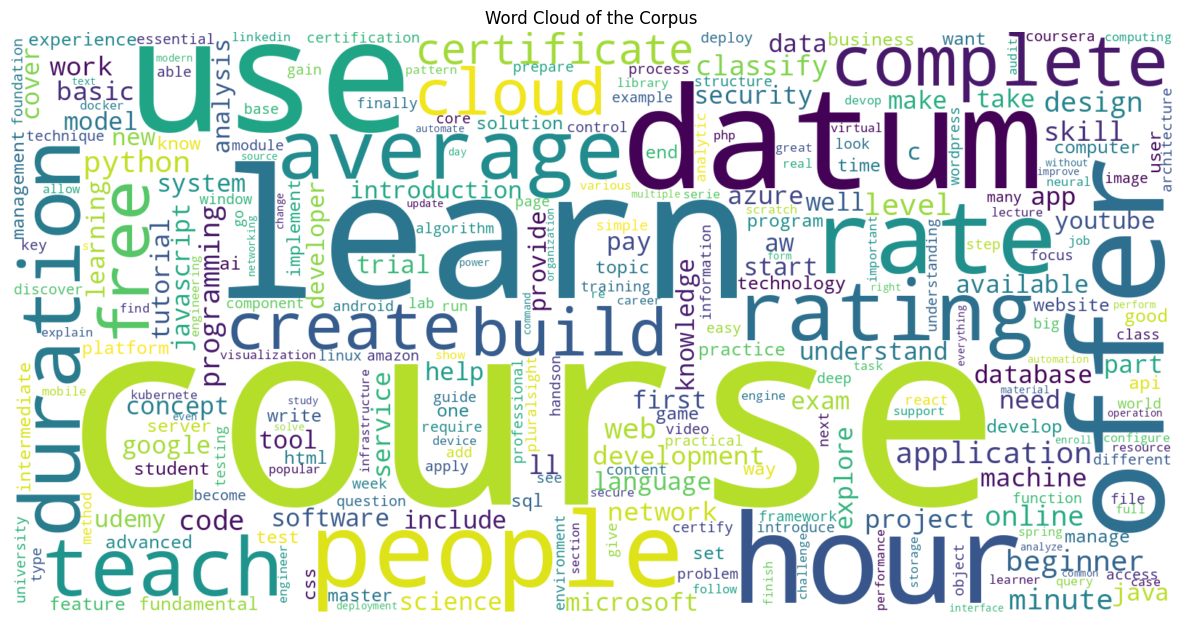

In [37]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', min_font_size=14,
                      collocations=False, max_words=500).generate(' '.join(df['preprocessed_details']))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of the Corpus')
plt.show()